In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.graphics.plot as plot

<br>

# SFS visualisation

In [2]:
cst = pd.read_json('./Data/SMC/optimization_smc/data/vcf_cst.zip')
growth = pd.read_json('./Data/SMC/optimization_smc/data/vcf_growth.zip')
# decline = pd.read_json('./Data/SMC/optimization_smc/data/vcf_decline.zip')

In [3]:
def plot_sfs(data, model):
    # Set up plot
    plt.figure(figsize=(12, 9), constrained_layout=True)
    
    for i, row in data.iterrows():
        # Color
        color = (0., 0. + (i/10), 1., 0.5)
        
        # Plot SFS
        #plt.plot(normalization(values['SFS']), label=species, color=color[values['Status']])
        with plt.style.context('seaborn-whitegrid'):  # use seaborn style for plot
            plt.plot(plot.normalization(row['SFS observed']), label="SFS - length={:.1e}".format(row['Parameters']['length']),
                     color=color, linestyle="dashed")

    # Plot theoritical SFS of any constant population
    theoretical_sfs = plot.compute_theoretical_sfs(len(row['SFS observed']))
    with plt.style.context('seaborn-whitegrid'):  # use seaborn style for plot
        plt.plot(plot.normalization(theoretical_sfs), label="Theoretical model - Fu, 1995", marker="o", color="tab:orange")

    # Label, caption & title
    plot.sfs_label(length=len(row['SFS observed']), title="SFS for SMC optimization - {} model".format(model))

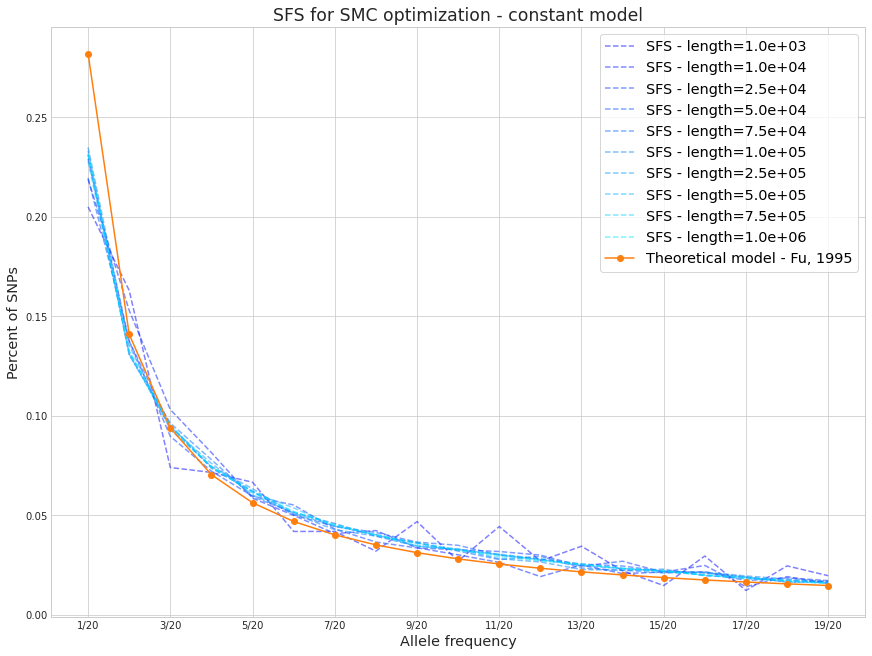

In [4]:
plot_sfs(cst[['Parameters', 'SFS observed']], model="constant")

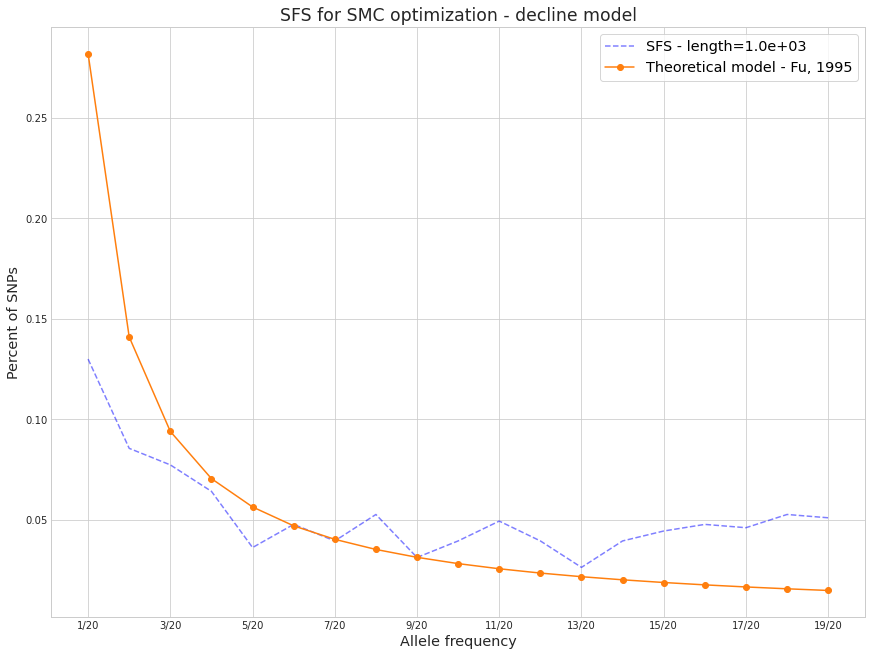

In [9]:
plot_sfs(decline[['Parameters', 'SFS observed']], model="decline")

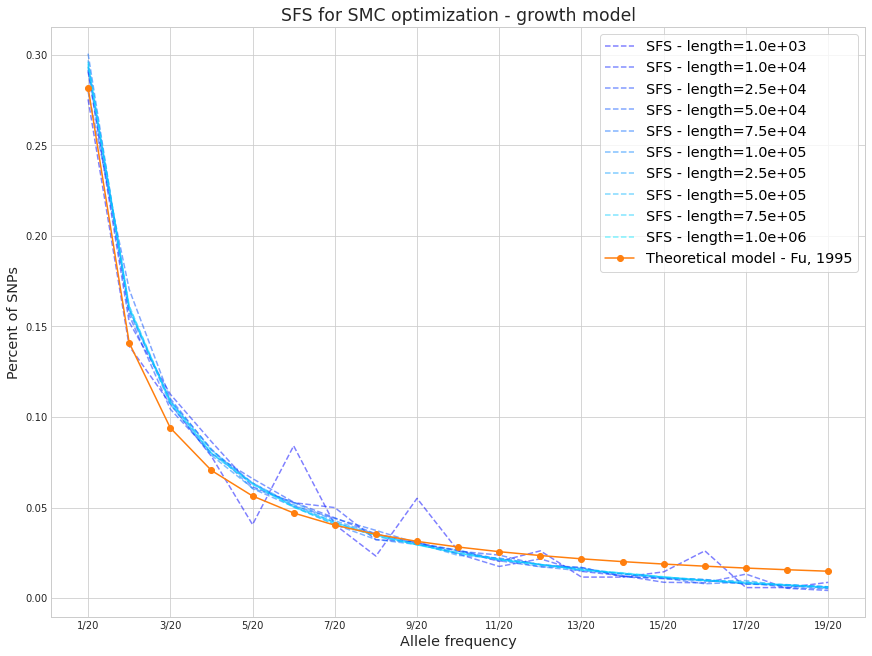

In [5]:
plot_sfs(growth[['Parameters', 'SFS observed']], model="growth")